# Structural ageing 
It is the ratio of the 65+ population to the total population in an area (per barri).

In [50]:
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
import numpy as np
import contextily as cx
import shapely.geometry as geom
from splot.libpysal import plot_spatial_weights

In [ ]:
import spreg

In [2]:
%run data.ipynb

## Exploratory Analysis of Spatial Data: Spatial Autocorrelation 


In [3]:
# Creating percentage of total groupby by age groups in barris 
#(number of people in certain age group divided by total population number)
population_tg_pct = population_tg.groupby(['Year', 'District_code', 'District_name', 
                       'Barri_code', 'Barri_name', 'Age_group']).agg({'Number': 'sum'}).groupby(level=["Year","Barri_name"]).apply(lambda x: 100 * x / float(x.sum())).reset_index()
population_tg_pct = population_tg_pct.merge(districts, on='District_code').merge(barris, on='Barri_code')
population_tg_pct.rename(columns={'geometry_x': 'geometry_district', 'geometry_y': 'geometry_barri'}, inplace=True)
population_tg_pct = gpd.GeoDataFrame(population_tg_pct, geometry=population_tg_pct['geometry_barri'])
population_tg_pct_65 = population_tg_pct.query('Age_group == "65 years and more"')
population_tg_pct_65.head()

,Year,District_code,District_name,Barri_code,Barri_name,Age_group,Number,geometry_district,geometry_barri,geometry
1,2010,1,Ciutat Vella,1,el Raval,65 years and more,13.917166,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."
4,2011,1,Ciutat Vella,1,el Raval,65 years and more,13.513627,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."
7,2012,1,Ciutat Vella,1,el Raval,65 years and more,12.925531,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."
10,2013,1,Ciutat Vella,1,el Raval,65 years and more,12.676230,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."
13,2014,1,Ciutat Vella,1,el Raval,65 years and more,12.645034,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ...","POLYGON ((2.16471 41.38593, 2.16936 41.38554, ..."


C:\Users\THINK\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(0.5, 1.0, '2019')

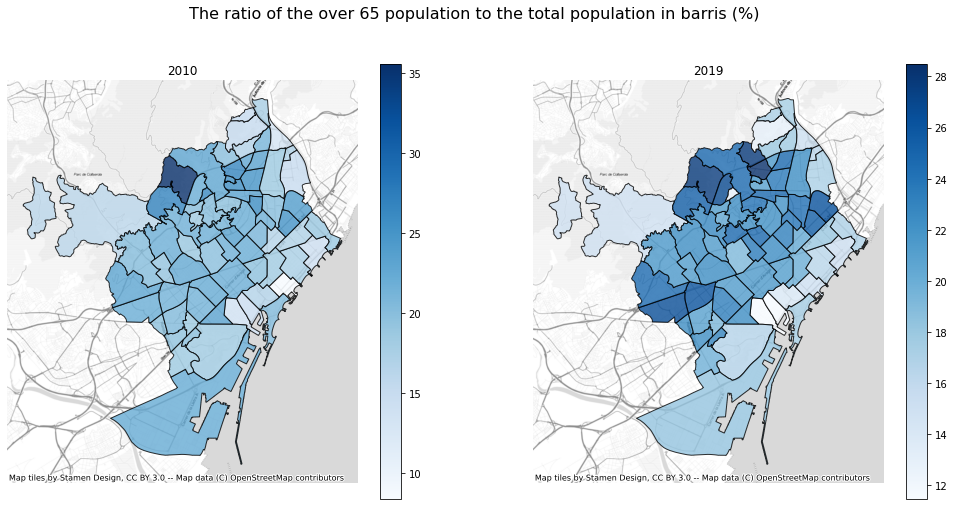

In [4]:
f, ax = plt.subplots(1,2,figsize=(2.16*8,8))

df = population_tg_pct_65
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs={"init": "epsg:4326"})
df = df.to_crs(epsg=3857)

df.query('Year == 2010').plot('Number', ax=ax[0], alpha=0.8, cmap='Blues', edgecolor='k', legend=True)
cx.add_basemap(ax[0], crs=df.crs, source=cx.providers.Stamen.TonerLite)
ax[0].axis('off')

df.query('Year == 2019').plot('Number', ax=ax[1], alpha=0.8, cmap='Blues', edgecolor='k', legend=True)
cx.add_basemap(ax[1], crs=df.crs, source=cx.providers.Stamen.TonerLite)
ax[1].axis('off')

f.suptitle('The ratio of the over 65 population to the total population in barris (%)', fontsize=16)
ax[0].set_title("2010")
ax[1].set_title("2019")

Text(0.5, 1.0, '2019')

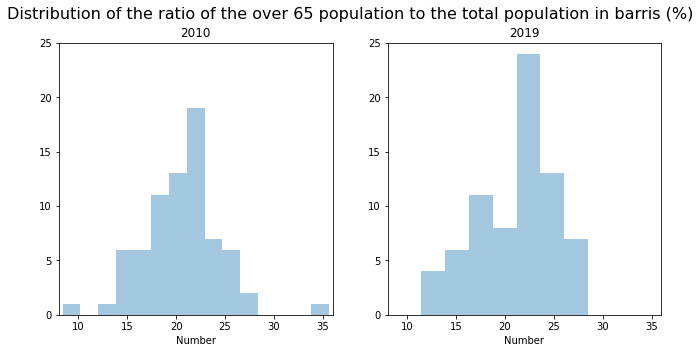

In [5]:
f, ax = plt.subplots(1,2,figsize=(2.16*5,5))

sns.distplot(df.query('Year == 2010').Number, kde=False, ax=ax[0])
sns.distplot(df.query('Year == 2019').Number, kde=False, ax=ax[1])
ax[0].set(xlim=(8, 36))
ax[1].set(xlim=(8, 36))
ax[0].set(ylim=(0, 25))
ax[1].set(ylim=(0, 25))

f.suptitle('Distribution of the ratio of the over 65 population to the total population in barris (%)', fontsize=16)
ax[0].set_title("2010")
ax[1].set_title("2019")

In [6]:
print('Description of the  65+ ratio in 2010')
df.query('Year == 2010').Number.describe()

Description of the  65+ ratio in 2010


count    73.000000
mean     20.522187
std       3.902573
min       8.398268
25%      18.497769
50%      20.510386
75%      22.388060
max      35.578387
Name: Number, dtype: float64

In [7]:
print('Description of the  65+ ratio in 2019')
df.query('Year == 2019').Number.describe()

Description of the  65+ ratio in 2019


count    73.000000
mean     20.986737
std       4.007028
min      11.473402
25%      17.925229
50%      21.589494
75%      23.720033
max      28.487729
Name: Number, dtype: float64

### Choosing the best classification approach

In [8]:
import mapclassify as mc

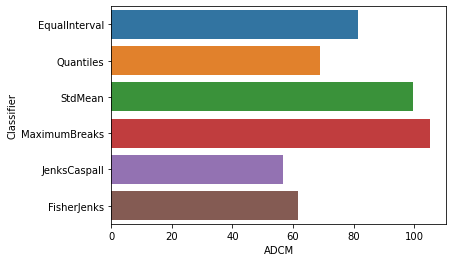

In [9]:
x = df.query('Year == 2010').Number
ei5 = mc.EqualInterval(x, k=5)
q5 = mc.Quantiles(x, k=5)
msd = mc.StdMean(x)
mb5 = mc.MaximumBreaks(x, k=5)
jc5 = mc.JenksCaspall(x, k=5)
fj5 = mc.FisherJenks(x, k=5)

class5 = ei5, q5, msd, mb5, jc5, fj5 
fits = np.array([ c.adcm for c in class5])
data = pd.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']
ax = sns.barplot(y='Classifier', x='ADCM', data=data)

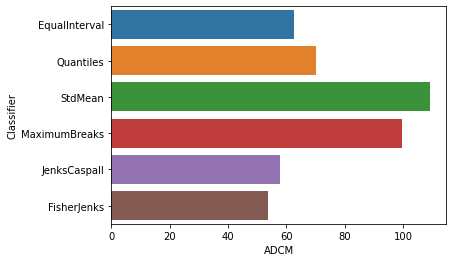

In [10]:
x = df.query('Year == 2019').Number
ei5 = mc.EqualInterval(x, k=5)
q5 = mc.Quantiles(x, k=5)
msd = mc.StdMean(x)
mb5 = mc.MaximumBreaks(x, k=5)
jc5 = mc.JenksCaspall(x, k=5)
fj5 = mc.FisherJenks(x, k=5)

class5 = ei5, q5, msd, mb5, jc5, fj5 
fits = np.array([ c.adcm for c in class5])
data = pd.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']
ax = sns.barplot(y='Classifier', x='ADCM', data=data)

**Fisher-Jenks** is an optimal algorithm which adopts a dynamic programming approach to minimize the sum of the absolute deviations around class medians. Fisher-Jenks is guaranteed to produce an optimal classification for a prespecified number of classes.

C:\Users\THINK\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


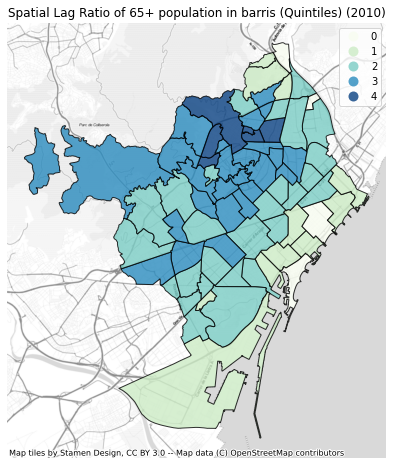

In [11]:
df = population_tg_pct_65.query('Year == 2010')
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs={"init": "epsg:4326"})
df = df.to_crs(epsg=3857)

wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'
y = df['Number']
ylag = lp.weights.lag_spatial(wq, y)

ylag_fj = mc.FisherJenks(ylag)
f, ax = plt.subplots(1, figsize=(8,8))
df.assign(cl=ylag_fj.yb).plot(column='cl', categorical=True, \
        cmap='GnBu', alpha=0.8, ax=ax, \
        edgecolor='k', legend=True)
cx.add_basemap(ax, crs=df.crs, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.title("Spatial Lag of Ratio of 65+ population in barris (Quintiles) (2010)")

plt.show()

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2fe4afc2708>)

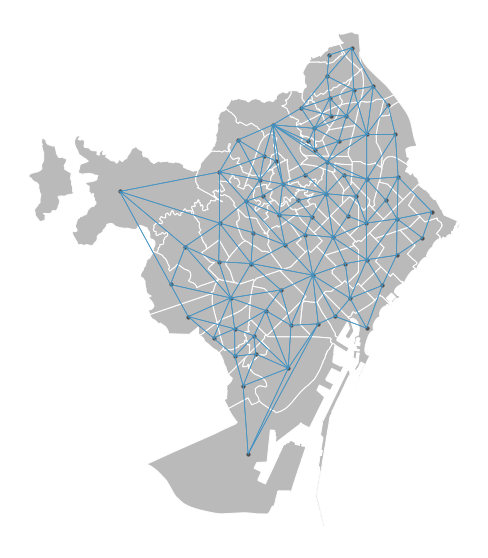

In [51]:
plot_spatial_weights(wq, df)

In [12]:
ylag_fj.adcm

39.89831252041151

In [13]:
ylag_fj

FisherJenks           

   Interval      Count
----------------------
[13.36, 16.21] |     4
(16.21, 18.84] |    11
(18.84, 20.97] |    27
(20.97, 23.07] |    25
(23.07, 26.35] |     6

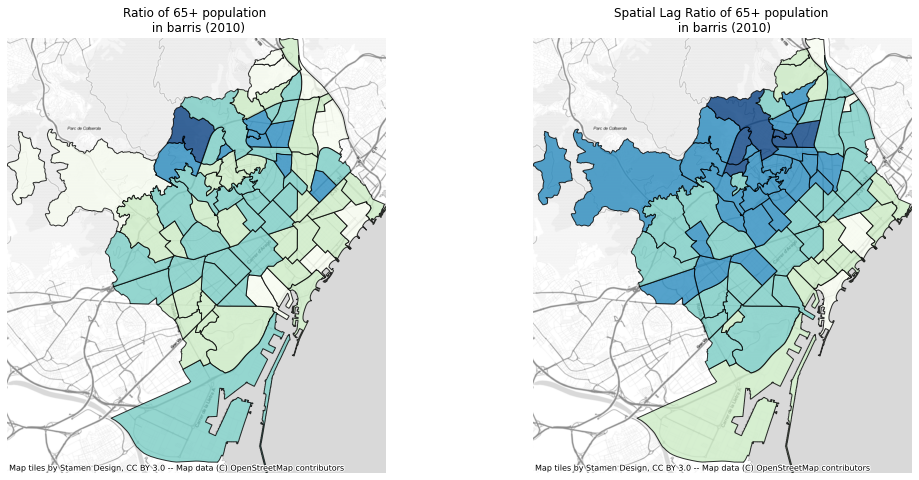

In [14]:
df['lag_Number'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*8,8))
df.plot(column='Number', ax=ax[0], edgecolor='k',
        scheme="FisherJenks", cmap='GnBu', alpha=0.8)
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Ratio of 65+ population \n in barris (2010)")
cx.add_basemap(ax[0], crs=df.crs, source=cx.providers.Stamen.TonerLite)

df.plot(column='lag_Number', ax=ax[1], edgecolor='k',
        scheme='FisherJenks', cmap='GnBu', alpha=0.8)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Ratio of 65+ population \n in barris (2010)")
cx.add_basemap(ax[1], crs=df.crs, source=cx.providers.Stamen.TonerLite)

ax[0].axis('off')
ax[1].axis('off')


plt.show()

C:\Users\THINK\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


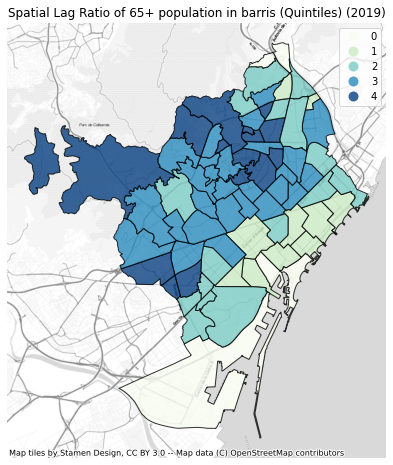

In [15]:
df = population_tg_pct_65.query('Year == 2019')
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs={"init": "epsg:4326"})
df = df.to_crs(epsg=3857)

wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'
y = df['Number']
ylag = lp.weights.lag_spatial(wq, y)

ylag_fj = mc.FisherJenks(ylag)
f, ax = plt.subplots(1, figsize=(8,8))
df.assign(cl=ylag_fj.yb).plot(column='cl', categorical=True, \
        cmap='GnBu', alpha=0.8, ax=ax, \
        edgecolor='k', legend=True)
cx.add_basemap(ax, crs=df.crs, source=cx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.title("Spatial Lag of Ratio of 65+ population in barris (Quintiles) (2019)")

plt.show()

In [17]:
ylag_fj

FisherJenks           

   Interval      Count
----------------------
[13.54, 16.13] |     5
(16.13, 18.96] |    10
(18.96, 21.36] |    16
(21.36, 23.17] |    27
(23.17, 24.78] |    15

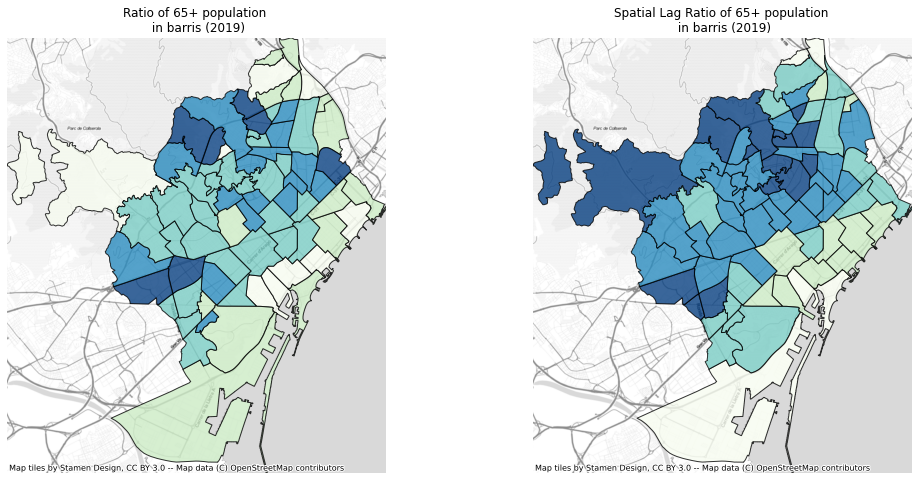

In [18]:
df['lag_Number'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*8,8))
df.plot(column='Number', ax=ax[0], edgecolor='k',
        scheme="FisherJenks", cmap='GnBu', alpha=0.8)
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Ratio of 65+ population \n in barris (2019)")
cx.add_basemap(ax[0], crs=df.crs, source=cx.providers.Stamen.TonerLite)

df.plot(column='lag_Number', ax=ax[1], edgecolor='k',
        scheme='FisherJenks', cmap='GnBu', alpha=0.8)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Ratio of 65+ population \n in barris (2019)")
cx.add_basemap(ax[1], crs=df.crs, source=cx.providers.Stamen.TonerLite)

ax[0].axis('off')
ax[1].axis('off')
plt.show()

## Global Spatial Autocorrelation

### Binary Case

In [19]:
y.median()

21.589494397815347

In [20]:
yb = y > y.median()
sum(yb)

36

In [21]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

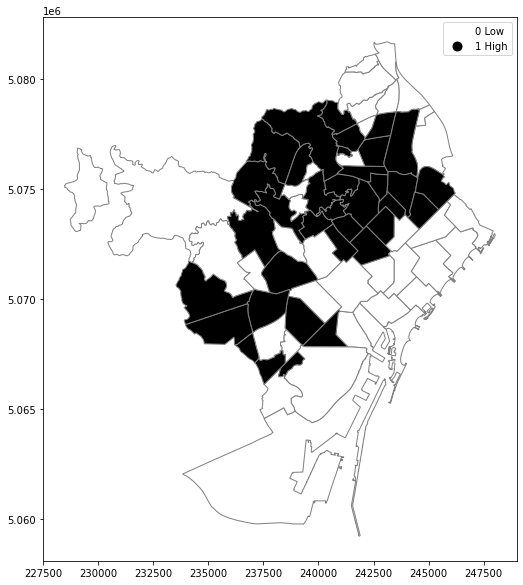

In [22]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts 

In [23]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

In [24]:
jc.bb

66.0

In [25]:
jc.ww

50.0

In [26]:
jc.bw

79.0

In [27]:
jc.bb + jc.ww + jc.bw

195.0

In [28]:
# unique number of joins in the spatial weights object
wq.s0 / 2

195.0

In [29]:
jc.mean_bb

46.76076076076076

Text(0.5, 0, 'BB Counts')

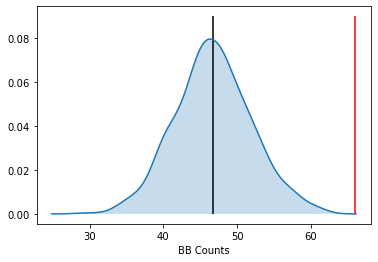

In [30]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, .09, color='r')
plt.vlines(jc.mean_bb, 0,.09)
plt.xlabel('BB Counts')

In [31]:
jc.p_sim_bb

0.001

### Continuous Case

In [32]:
wq.transform = 'r'

In [33]:
y = df['Number']

In [34]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.36011970778664026

Text(0.5, 0, "Moran's I")

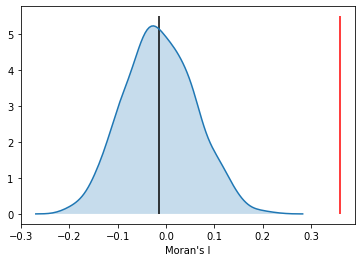

In [35]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 5.5, color='r')
plt.vlines(mi.EI, 0,5.5)
plt.xlabel("Moran's I")

In [36]:
mi.p_sim

0.001

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers 

In [37]:
np.random.seed(12345)
import esda

In [38]:
wq.transform = 'r'
lag_number = lp.weights.lag_spatial(wq, df['Number'])

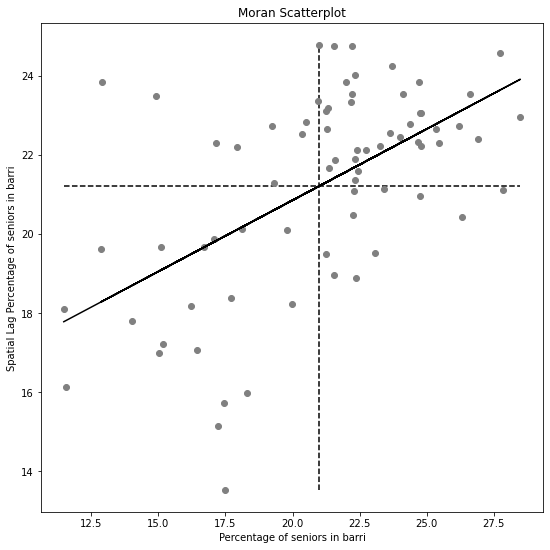

In [53]:
number = df['Number']
b, a = np.polyfit(number, lag_number, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(number, lag_number, 'o', color='grey')

plt.vlines(number.mean(), lag_number.min(), lag_number.max(), linestyle='--')
plt.hlines(lag_number.mean(), number.min(), number.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(number, a + b*number, 'k')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag Percentage of seniors in barri')
plt.xlabel('Percentage of seniors in barri')
plt.show()


In [40]:
li = esda.moran.Moran_Local(y, wq)
li.q

array([3, 3, 3, 3, 4, 1, 4, 1, 1, 4, 3, 3, 3, 4, 2, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 4, 3, 3, 3, 3, 3, 3, 2, 4, 1, 1, 1, 1, 2, 3,
       3, 3, 3, 3, 3, 1, 4])

In [41]:
(li.p_sim < 0.05).sum()

19

In [42]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, 3, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 0, 0, 0, 0, 0])

In [43]:
spot_labels = [ '0 ns', '1 HH (hot spot)', '2 LH (doughnut)', '3 LL (cold spot)', '4 HL (diamond)']
labels = [spot_labels[i] for i in spots]

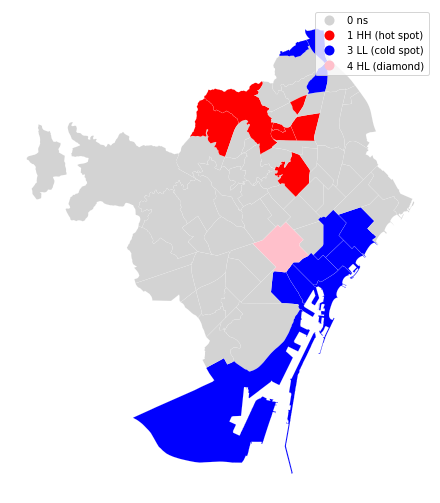

In [48]:
from matplotlib import colors
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

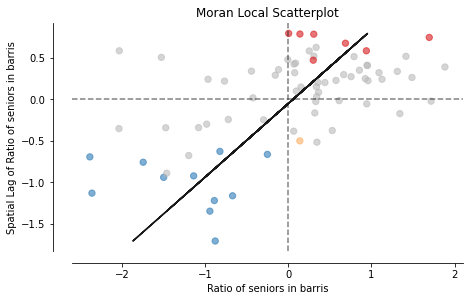

In [45]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(li, p=0.05)
ax.set_xlabel('Ratio of seniors in barris')
ax.set_ylabel('Spatial Lag of Ratio of seniors in barris')
plt.show()

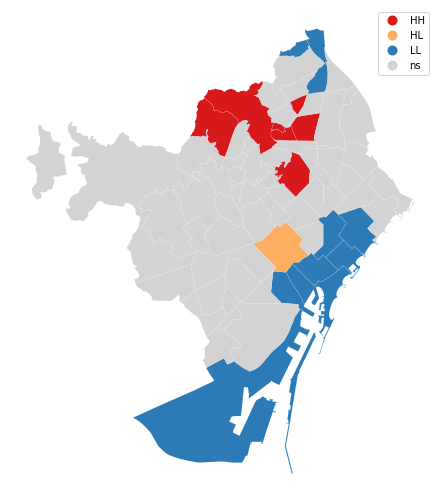

In [46]:
from splot.esda import lisa_cluster
lisa_cluster(li, df, p=0.05, figsize = (9,9))
plt.show()